# Goals and Overview

The goal of this project is to find patterns in the available information in order to understand passenger preferences and the impact of external factors on rides. I will begin by looking over the data for any changes I can make that will help the analysis, like fixing missing or duplicate values, fixing values with unoptimal data types, and fixing unoptimal column names. I will then look for anyways that I can enrich the data so my observations are richer and more accurate. Lastly I will create certian graphs to visualize important parts of the data, so meaningful conclusions may be visualized.

# Project

## Initialization

In [2]:
import pandas as pd
import re
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

## Reading Data

In [3]:
companies_df = pd.read_csv('./datasets/moved_project_sql_result_01.csv')
neighborhoods_df = pd.read_csv('./datasets/moved_project_sql_result_04.csv')
weather_df = pd.read_csv('./datasets/moved_project_sql_result_07.csv')

### Companies

In [4]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [5]:
companies_df

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,"2241 - 44667 - Felman Corp, Manuel Alonso",3


__Missing Data__

In [7]:
companies_df.isna().sum()

company_name    0
trips_amount    0
dtype: int64

__Duplicate Data__

In [8]:
companies_df.duplicated().sum()

0

### Neighborhoods

In [9]:
neighborhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [10]:
neighborhoods_df

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
...,...,...
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538


__Missing Data__

In [11]:
neighborhoods_df.isna().sum()

dropoff_location_name    0
average_trips            0
dtype: int64

__Duplicate Data__

In [12]:
neighborhoods_df.duplicated().sum()

0

### Weather

In [13]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [14]:
weather_df

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


__Missing Data__

In [15]:
weather_df.isna().sum()

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

__Duplicate Data__

In [16]:
weather_df.duplicated().sum()

197

In [19]:
weather_df[weather_df.duplicated()]

,start_ts,weather_conditions,duration_seconds
62,2017-11-11 06:00:00,Good,1260.0
74,2017-11-11 08:00:00,Good,1380.0
76,2017-11-04 09:00:00,Good,1380.0
117,2017-11-11 07:00:00,Good,1380.0
119,2017-11-04 14:00:00,Good,3300.0
...,...,...,...
1054,2017-11-11 07:00:00,Good,1380.0
1058,2017-11-25 12:00:00,Good,1440.0
1062,2017-11-11 06:00:00,Good,1500.0
1065,2017-11-11 13:00:00,Good,2100.0


In [20]:
weather_df[weather_df['start_ts'] == '2017-11-11 06:00:00'].head()

,start_ts,weather_conditions,duration_seconds
43,2017-11-11 06:00:00,Good,1260.0
62,2017-11-11 06:00:00,Good,1260.0
81,2017-11-11 06:00:00,Good,1346.0
101,2017-11-11 06:00:00,Good,1475.0
122,2017-11-11 06:00:00,Good,1218.0


We are unsure about the nature of these duplicates. The data does not show the minutes of the times, which are rounded to the nearest hour. Additionally, we don't know where each record of a trip started and ended. It is possible that multiple cabs picked up and dropped off in the same places within the same starting hour. So, the records could actually be distinct.

## Data Preparation

In [21]:
companies_df = companies_df.rename(columns={'company_name': 'Company Name', 'trips_amount': 'Total Trips'})

In [22]:
neighborhoods_df = neighborhoods_df.rename(columns={'dropoff_location_name': 'Neighborhood', 'average_trips': 'Average Trips'})

In [23]:
neighborhoods_df['Average Trips'] = neighborhoods_df['Average Trips'].astype('int64')

In [25]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Company Name  64 non-null     object
 1   Total Trips   64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [24]:
neighborhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Neighborhood   94 non-null     object
 1   Average Trips  94 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


Column names for neighborhood_df have been changed from 'dropoff_location_name' to 'Neighborhood' and 'average_trips' to 'Average Trips'.

Column names for companies_df have been changed from 'company_name' to 'Company Name' and 'trips_amount' to 'Trips Amount'.

## Data Analysis

In [26]:
top_10_neighborhoods = neighborhoods_df.sort_values(by='Average Trips', ascending=False).head(10)
top_10_neighborhoods

,Neighborhood,Average Trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546
5,Lake View,2420
6,Grant Park,2068
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1259


C:\Users\crisl\AppData\Local\Temp\ipykernel_13652\4162757015.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_neighborhoods, x='Average Trips', y='Neighborhood', palette='viridis')


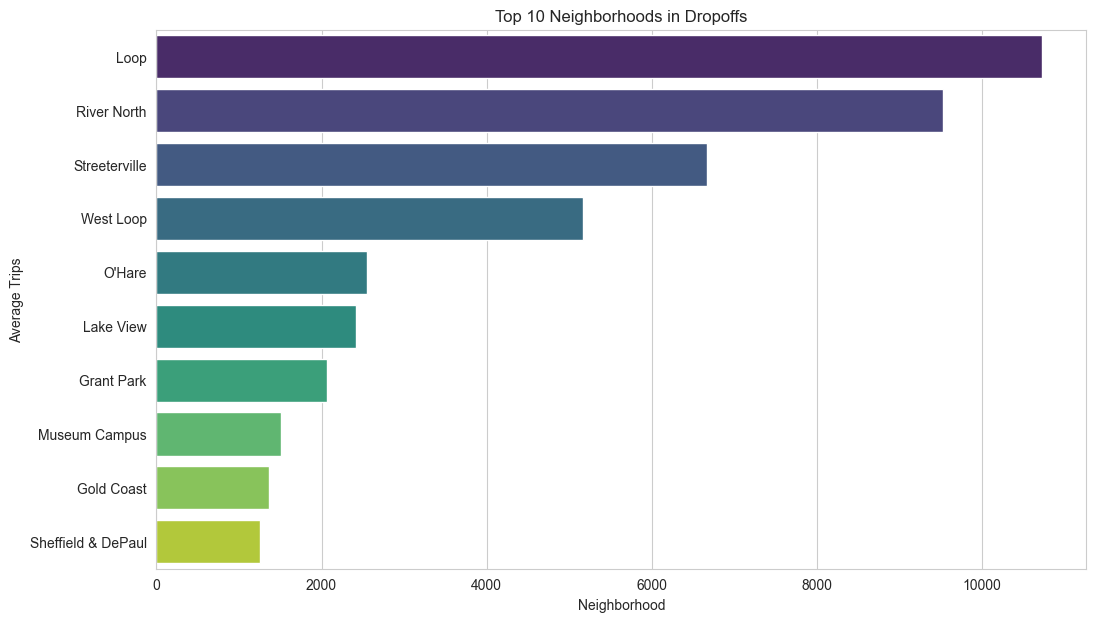

In [27]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_neighborhoods, x='Average Trips', y='Neighborhood', palette='viridis')

plt.title('Top 10 Neighborhoods in Dropoffs')
plt.xlabel('Neighborhood')
plt.ylabel('Average Trips')

plt.show()

The TOP 10 neighborhoods in drop offs are:

- Loop: The Loop neighborhood has the highest average number of trips, with approximately 10,727 trips.

- River North: River North follows closely behind the Loop with an average of 9,524 trips..

- Streeterville: Streeterville has an average of 6,665 trips..

- West Loop: The West Loop neighborhood has an average of 5,164 trips.

- O'Hare: O'Hare has a comparatively lower average number of trips at 2,547.

- Lake View: Lake View has an average of 2,421 trips.

- Grant Park: Grant Park has an average of 2,069 trips.

- Museum Campus: Museum Campus has an average of 1,510 trips.

- Gold Coast: The Gold Coast neighborhood has an average of 1,364 trips.

- Sheffield & DePaul: Sheffield & DePaul has the lowest average number of trips at 1,260.

In [28]:
top_10_companies = companies_df.sort_values(by='Total Trips', ascending=False).head(10)
top_10_companies

,Company Name,Total Trips
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


C:\Users\crisl\AppData\Local\Temp\ipykernel_13652\2296468039.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_companies, x='Total Trips', y='Company Name', palette='viridis')


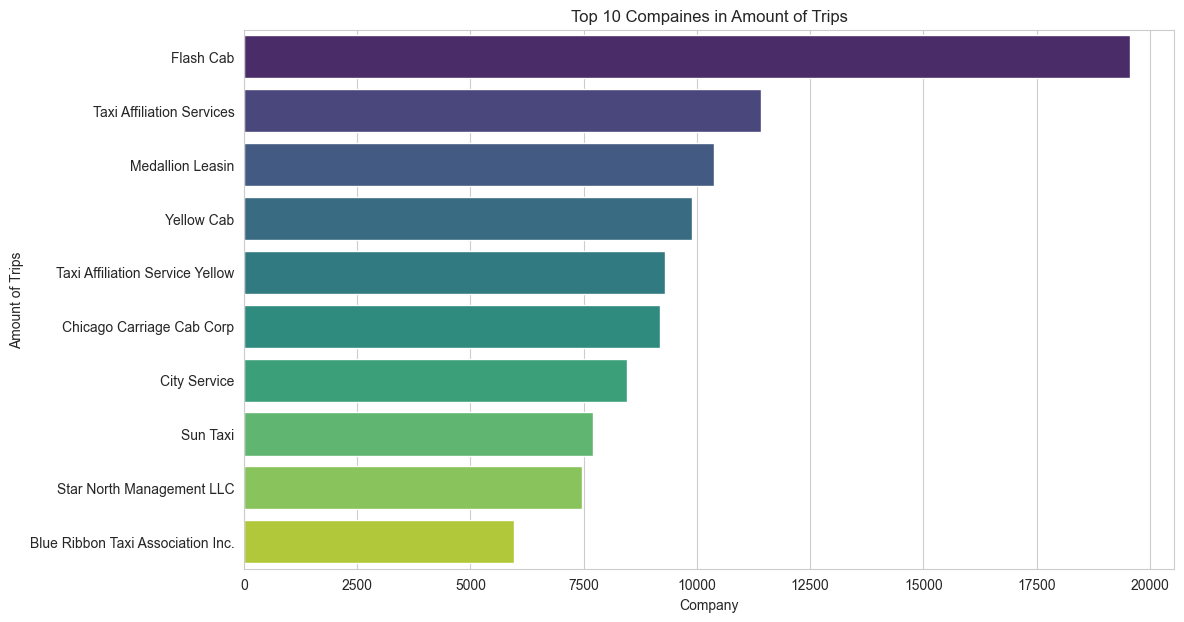

In [29]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_companies, x='Total Trips', y='Company Name', palette='viridis')

plt.title('Top 10 Compaines in Amount of Trips')
plt.xlabel('Company')
plt.ylabel('Amount of Trips')

plt.show()

Based on the total number of trips by each taxi company, it's evident that Flash Cab leads the pack with 19,558 trips, indicating its popularity and possibly its extensive fleet size or efficient service. Taxi Affiliation Services follows behind Flash Cab with 11,422 trips, indicating a considerable customer base but still significantly lower than Flash Cab.

Medallion Leasing and Yellow Cab have similar total trip counts, suggesting they are also prominent players in the taxi industry within the area. Taxi Affiliation Service Yellow and Chicago Carriage Cab Corp closely trail with total trip counts of 9,299 and 9,181, respectively, showcasing their significant presence in the market.

City Service, Sun Taxi, and Star North Management LLC have comparable total trip counts, indicating they are also active participants in the taxi service sector but possibly with smaller fleets or market shares compared to the leading companies.

Blue Ribbon Taxi Association Inc. has the lowest total number of trips among the listed companies, indicating it may have a smaller market share or less visibility compared to its competitors.

Overall, Flash Cab appears to be the dominant player in terms of total trips, while other companies also contribute significantly to the taxi service landscape in the area.

## Testing Statistical Hypothesis

In [32]:
rainy = weather_df[weather_df['weather_conditions'] == 'Bad']['duration_seconds']
not_rainy =  weather_df[weather_df['weather_conditions'] == 'Good']['duration_seconds']

results = st.ttest_ind(rainy, not_rainy)

print("P-value:", results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print("Reject the null hypothesis: There is a statistically significant difference in the average duration of rides from the Loop to O'Hare International Airport between rainy Saturdays and other days.")
else:
    print("Fail to reject the null hypothesis: There is no statistically significant difference in the average duration of rides from the Loop to O'Hare International Airport Saturdays between rainy Saturdays and other days.")

P-value: 6.517970327099473e-12
Reject the null hypothesis: There is a statistically significant difference in the average duration of rides from the Loop to O'Hare International Airport between rainy Saturdays and other days.


A probablility value of 6.517970327099473e-12 or (0.00000000000652) indicates an extremely low probability of observing the data if the null hypothesis were true.
Based on wanting to see if the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays, my Null Hypothesis (H0) is: The average duration of rides from the Loop to O'Hare International Airport is the same between rainy Saturdays and other days.

H₀ is always stated with an equal sign. "The mean of the population in question equals A” in this case the average duration of rides from the Loop to O'Hare International Airport on Rainy Saturdays equals The average duration of rides from the Loop to O'Hare International Airport on other days.

Making the Alternative Hypothesis (H1): The average duration of rides from the Loop to O'Hare International Airport rainy Saturdays and other days differs.

I will be using the duration in seconds for each weather_condition as the criterion, because this is the target we want to compare.

For the alpha I will be using 0.05 because using anything above that will cause every 20 or so experiments to reject the hypothesis not because it's wrong, but because the real value turned out to be far from the proposed value.

## Conclusion

The Loop emerges as the neighborhood with the highest average number of trips, followed closely by River North and Streeterville. This indicates that these areas are likely bustling with activity and have high demand for taxi services. On the other hand, Sheffield & DePaul has the lowest average number of trips, suggesting it may be a less busy or less populated area in comparison.

Flash Cab stands out as the top-performing taxi company with the highest total number of trips, followed by Taxi Affiliation Services. These companies likely have a strong presence in the market and may offer reliable services, leading to their popularity among customers. Other companies such as Medallion Leasing, Yellow Cab, and Taxi Affiliation Service Yellow also contribute significantly to the total trips, indicating a competitive landscape in the taxi industry.

The analysis of the average duration of rides from the Loop to O'Hare International Airport on rainy Saturdays versus other days reveals a statistically significant difference. The rejection of the null hypothesis suggests that weather conditions, specifically rain, have a notable impact on ride durations. This finding implies that taxi services may experience delays or changes in travel times during inclement weather, which could affect customer satisfaction and operational efficiency.